In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
class FeatureEngineering():
    def __init__(self):
        self._cabinKnown = False
        self._title = False
        self._familySize = False
        self._isMinor = False
        self._isMinorThresh = 0

    def _familyCategorise(self, s):
        if s>= 4:
            return 'large'
        if s == 0:
            return 'alone'
        if s > 0 and s < 4:
            return 'normal'
    

    def cabinKnown(self, df):
        self._cabinKnown = True
        return df['Cabin'].isnull() == False


    def title(self, df):
        self._title = True
        titles = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

        mr_alias = ['Don', 'Rev', 'Dr', 'Major', 'Sir', 'Col', 'Capt', 'Jonkheer']
        miss_alias = ['Mlle', 'Ms']
        mrs_alias = ['Mme', 'Lady', 'the Countess']

        titles[titles.isin(mr_alias)] = 'Mr'
        titles[titles.isin(miss_alias)] = 'Miss'
        titles[titles.isin(mrs_alias)] = 'Mrs'
        return titles.astype('category')


    def familySize(self, df):
        self._familySize = True
        family = df['Parch'] + df['SibSp']
        return pd.Categorical(list(map(self._familyCategorise, family)), ordered=True)


    def isMinor(self, df, threshold):
        # Try thresholds 14 and 9 to start off with, aim is to balanced 
        # maximising difference between groups while also capturing 
        # most information possible
        self._isMinor = True
        self._isMinorThresh = threshold
        return pd.Categorical(np.digitize(df['Age'], [threshold, 0]))


    def getSummary(self):
        s = "cabinKnown:\t\t{}\ntitle:\t\t\t{}\nfamilySize:\t\t{}\nisMinor (age < {}):\t{}".format(
            self._cabinKnown, self._title, self._familySize, self._isMinorThresh, self._isMinor)
        
        return s

In [3]:
def coerce_types(df):
    ndf = df.copy()
    ndf.Pclass = ndf.Pclass.astype("category", categories=[1, 2, 3], ordered=True)
    ndf.Sex = ndf.Sex.astype("category")
    ndf.Embarked = ndf.Embarked.astype("category")
    return ndf


def naSummary(df):
    return df.isnull().sum()


def engineer_features(df):
    ndf = df.copy()
    ndf['CabinKnown'] = FE.cabinKnown(ndf)
    ndf['Title'] = FE.title(ndf)
    ndf['FamilySize'] = FE.familySize(ndf)
    ndf['IsMinor'] = FE.isMinor(ndf, 14)
    return ndf

In [4]:
train = pd.read_csv('../input/train_pp.csv')
test = pd.read_csv('../input/test_pp.csv')

In [5]:
FE = FeatureEngineering()

combine = pd.concat([train.drop('Survived', 1), test])
combine.reset_index(inplace=True, drop=True) 
combine = coerce_types(combine)
combine_eng = engineer_features(combine)

combine_eng.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinKnown,Title,FamilySize,IsMinor
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,Mr,normal,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,Mrs,normal,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,Miss,alone,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,Mrs,normal,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,Mr,alone,0


In [6]:
naSummary(combine_eng)

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
CabinKnown        0
Title             0
FamilySize        0
IsMinor           0
dtype: int64

In [7]:
missing_fares = combine_eng[combine_eng['Fare'].isnull()].index.tolist()

for fare in missing_fares:
    pclass = combine_eng.iloc[fare]['Pclass']
    combine_eng.set_value(fare, 'Fare', combine_eng[combine_eng['Pclass'] == pclass]['Fare'].mean())

missing_embarks = combine_eng[combine_eng['Embarked'].isnull()].index.tolist()
mcl = combine_eng['Embarked'].value_counts().idxmax()
for eb in missing_embarks:
    combine_eng.set_value(eb, 'Embarked', mcl)
    
naSummary(combine_eng)

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
CabinKnown        0
Title             0
FamilySize        0
IsMinor           0
dtype: int64

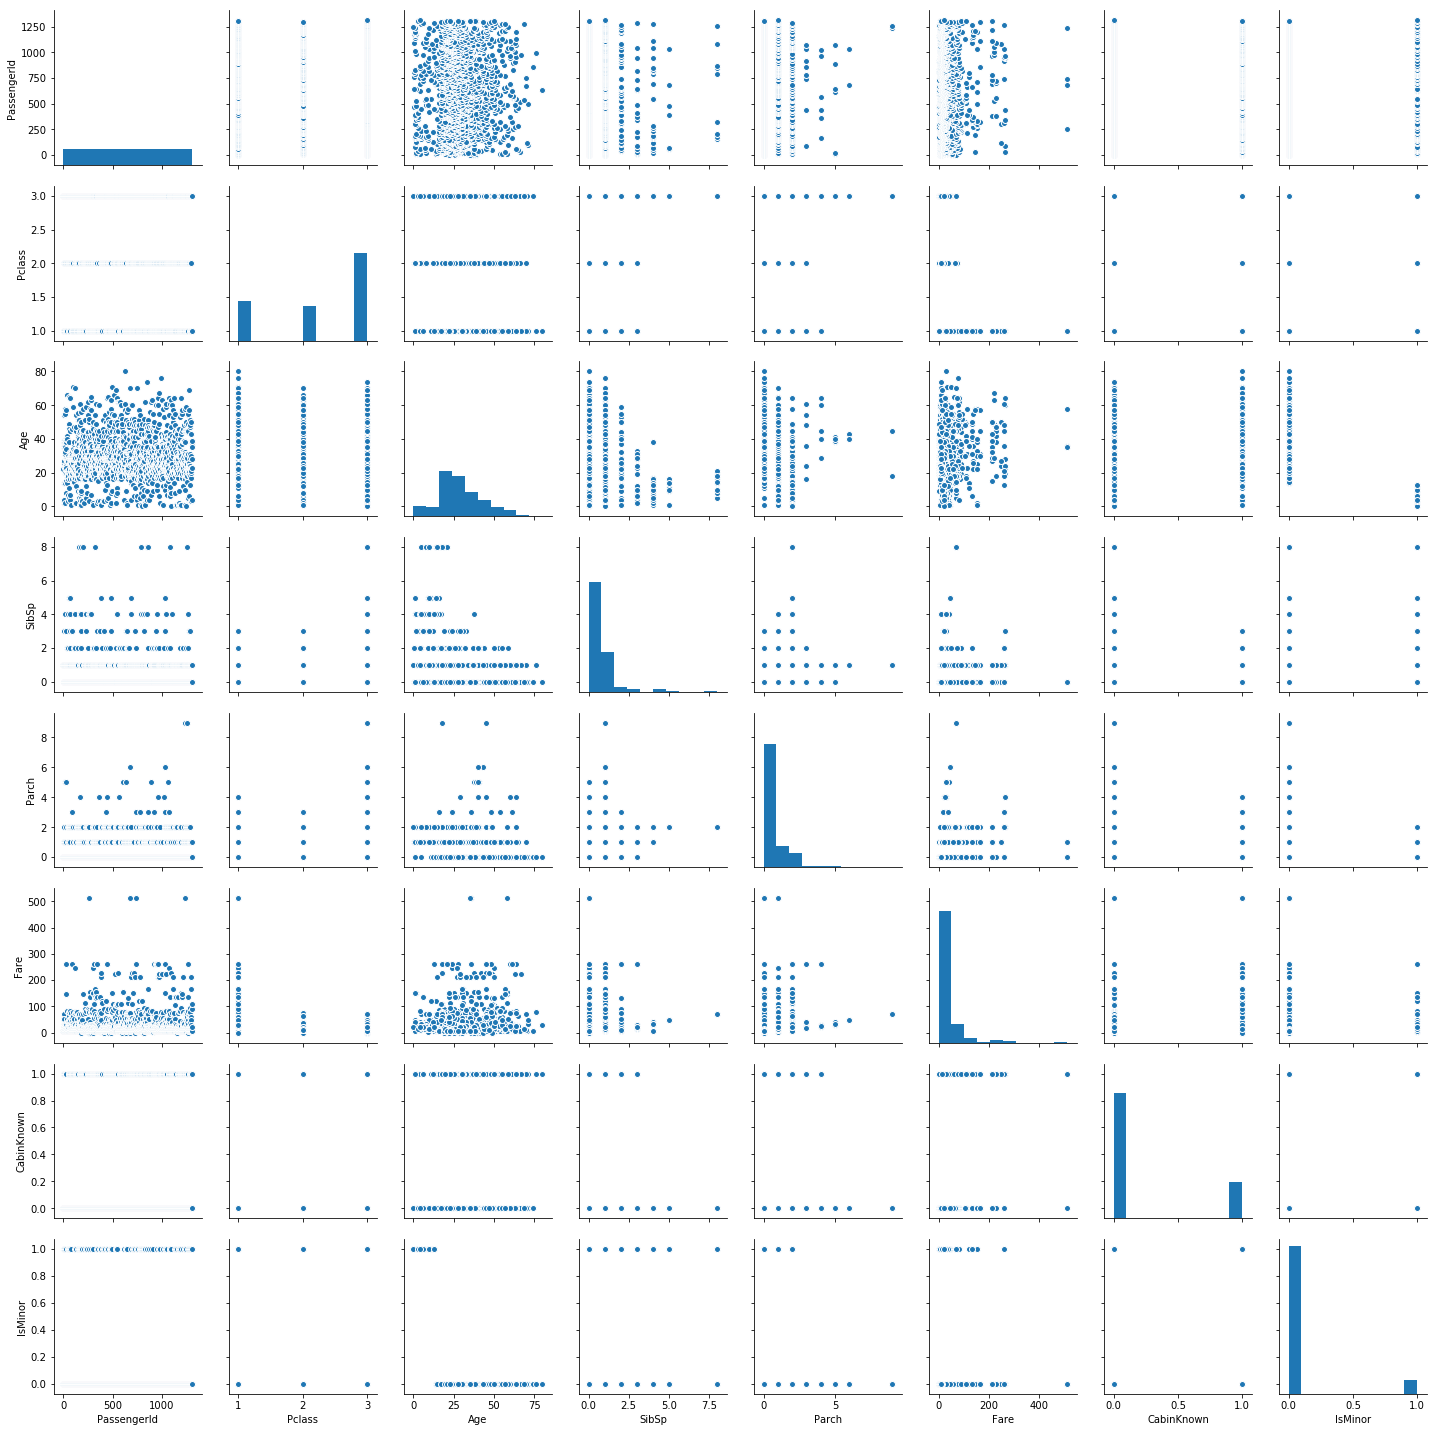

In [8]:
%matplotlib inline
sns.pairplot(combine_eng)

In [9]:
combine_eng[combine_eng['Fare'] == 0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinKnown,Title,FamilySize,IsMinor
179,180,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,False,Mr,alone,0
263,264,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,True,Mr,alone,0
271,272,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,False,Mr,alone,0
277,278,2,"Parkes, Mr. Francis ""Frank""",male,21.0,0,0,239853,0.0,NaN,S,False,Mr,alone,0
302,303,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,False,Mr,alone,0
413,414,2,"Cunningham, Mr. Alfred Fleming",male,22.0,0,0,239853,0.0,NaN,S,False,Mr,alone,0
466,467,2,"Campbell, Mr. William",male,29.0,0,0,239853,0.0,NaN,S,False,Mr,alone,0
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,39.0,0,0,239854,0.0,NaN,S,False,Mr,alone,0
597,598,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,False,Mr,alone,0
633,634,1,"Parr, Mr. William Henry Marsh",male,30.0,0,0,112052,0.0,NaN,S,False,Mr,alone,0


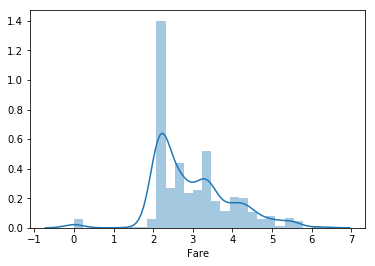

In [10]:
sns.distplot(np.log(combine_eng['Fare']+1))

In [11]:
combine_eng.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinKnown,Title,FamilySize,IsMinor
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,Mr,normal,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,Mrs,normal,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,Miss,alone,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,Mrs,normal,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,Mr,alone,0


In [12]:
combine_eng['IsMinor'].cat.codes

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       1
8       0
9       0
10      1
11      0
12      0
13      0
14      0
15      0
16      1
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      1
25      0
26      0
27      0
28      0
29      0
       ..
1279    0
1280    1
1281    0
1282    0
1283    1
1284    0
1285    0
1286    0
1287    0
1288    0
1289    0
1290    0
1291    0
1292    0
1293    0
1294    0
1295    0
1296    0
1297    0
1298    0
1299    0
1300    1
1301    0
1302    0
1303    0
1304    0
1305    0
1306    0
1307    0
1308    1
Length: 1309, dtype: int8

In [13]:
pd.Categorical(train['Cabin'].isnull() == False)

[False, True, False, True, False, ..., False, True, False, True, False]
Length: 891
Categories (2, object): [False, True]

In [14]:
combine_eng[:len(train)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinKnown,Title,FamilySize,IsMinor
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,Mr,normal,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,True,Mrs,normal,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,Miss,alone,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,Mrs,normal,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,Mr,alone,0
5,6,3,"Moran, Mr. James",male,39.0,0,0,330877,8.4583,NaN,Q,False,Mr,alone,0
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,True,Mr,alone,0
7,8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,False,Master,large,1
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,False,Mrs,normal,0
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,False,Mrs,normal,0


In [15]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,39.0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


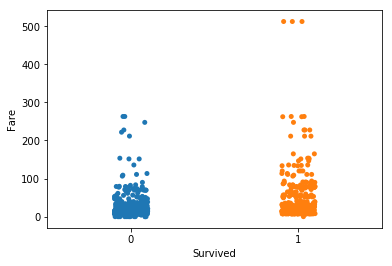

In [19]:
sns.stripplot(x='Survived', y='Fare', data=train, jitter=True)

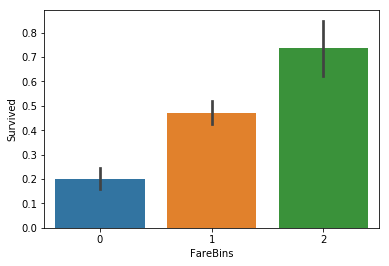

In [53]:
bins = [10, 100]
train['FareBins'] = np.digitize(train['Fare'], bins)

sns.barplot(x='FareBins', y='Survived', data=train)

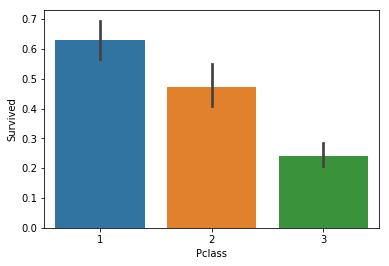

In [30]:
sns.barplot(x='Pclass', y='Survived', data=train)